In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
%load_ext autoreload
%autoreload 2


### Data Transformation from numpy_imags into torch and construct torch dataset

#### 1. loading data

In [ ]:
import matplotlib.image as mpimg

In [ ]:
'''
Load imags using mping function and return all data list
'''

def load_data_set(path, imag_indices, test=False):
    imgs = []
    print ('Loading {} satlite images...'.format(len(imag_indices)), end='') # for checking
    
    if not test:  #for training feature and groundtruth dataset
        for i in imag_indices:
            imag_name = path + 'satImage_{:03d}.png'.format(i) # the imag name format
            if os.path.isfile(imag_name):
                img = mpimg.imread(imag_name)   # read all imags in the file
                imgs.append(img)
            else:
                print('imag {} does not exists'.format(imag_name)) # for checking wrongly path
    
    else:  # for test dataset
        for i in imag_indices:
            imag_path = path + 'test_{:01d}/'.format(i)
            imag_name = imag_path + 'test_{:01d}.png'.format(i)
            if os.path.isfile(imag_name):
                imag = mpimg.imread(imag_name)
                imgs.append(imag)
            else:
                print('imag {} does not exists'.format(imag_name))
    return imgs

#### 2. Get patch_set

In [ ]:
'''
Without overlapping with neighboring patches
Ps: if the size of imag is not multiplier of the patch size, 
we use mirroring method to extend the border with one patch 
size according to ref[1]
'''

def get_patch(imag, patch_size):
    patch_set = []
    height, width = imag.shape[0], imag.shape[1]
    
    imag_mir = extend_boder(imag, patch_size)
    
    is_label = len(imag.shape) == 2 # since the groundtruth data set only does not have chanel dimension
    
    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            if is_label:
                patch = imag[j:j+patch_size, i:i+patch_size]
            else:
                patch = imag[j:j+patch_size, i:i+patch_size, :]
            
            patch_set.append(patch)
    
    return patch_set
    

In [ ]:
def extend_boder(imag, length):
    height, width = imag.shape[0], imag.shape[1]
    is_label = len(imag.shape) == 2
    
    '''to extend the right border'''
    if is_label:
        right_flipped = np.fliplr(imag[:, width - length:])
    else:
        right_flipped = np.fliplr(imag[:, width - length:, :])
        
    right_extend = np.concatenate((imag, right_flipped), axis=1)
    
    '''to extend the bottom border'''
    if is_label:
        bottom_extend = np.flipud(right_extend[height - length:, :])
    else:
        bottom_extend = np.flipud(right_extend[height - length:, :, :])
        
    extend = np.concatenate((right_extend, bottom_extend), axis=0)
    
    return extend

Reference: [1] Olaf Ronneberger, Philipp Fischer, and Thomas Brox, U-Net: Convolutional Networks for Biomedical Image Segmentation.

In [ ]:
'''
With overlapping for mutual patches
Ps: it's better to use multiplier factors. For example: the imag size is 400x400, and 
the patch size is 40x40, then the step is better to set as 6/10/20/40/60.. 
which (400-40)=360 is a muptiplier of the step in order to get all the pixels information.
'''
from skimage.util import view_as_windows

def get_patch_ovelap(imag, patch_size, step):
    
    is_label = len(imag.shape) == 2
    
    if is_label:
        window_size = (patch_size, patch_size) # gt does not have channel dimention
    else:
        window_size = (patch_size, patch_size, 3) # image with RGB channel
        
    slide_windows = view_as_windows(imag, window_size, step) # slide window to pick up patches with overlapping
    
    patches = []
    for i in range(0, slide_windows.shape[0], 1):
        for j in range(0, slide_windows.shape[1], 1):
            if is_label:
                patches.append(slide_windows[i][j])
            else:
                patches.append(slide_windows[i][j][0])
    
    return patches    

#### Get train and test dataset (nparray)

In [ ]:
def prepare_trainset(imag_path, label_path, imag_indices, patch_size, overlap, step):
    images = load_data_set(imag_path, imag_indices)
    labels = load_data_set(label_path, imag_indices)
    
    if overlap:
        image_patches = [patch for im in images for patch in get_patch_ovelap(im, patch_size, step)]
        label_patches = [patch for label in labels for patch in get_patch_ovelap(label, patch_size, step)]
    else:
        image_patches = [patch for im in images for patch in get_patch(im, patch_size)]
        label_patches = [patch for label in labels for patch in get_patch(label, patch_size)]
        
    return image_patches, label_patches

In [ ]:
def prepare_testdata(test_path, test_indices):
    test_images = load_data_set(test_path, test_indices, test=True)
    return test_images

#### 3. self-construct torch dataset

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose
from skimage import img_as_ubyte

In [ ]:
'''
First of all, we should transform labels into binary form
'''

def label_to_torch(label):
    label_treshold = 0.5
     
    label_torch = torch.from_numpy(label).float().unsqueeze(0)
    
    label_torch[label_torch < label_treshold] = 0  # transform into binary range [0,1]
    label_torch[label_torch >= label_treshold] = 1
    
    return label_torch

In [ ]:
class Patch_dataset(Dataset):
    
    def __init__(self, imag_path, label_path, imag_indices, patch_size, overlap, step):
        self.patch_feat, self.patch_label = prepare_trainset(imag_path, label_path, imag_indices, patch_size, overlap, step)
        
    def __getitem__(self,index): # design get function according to index
        patch_feat = torch.from_numpy(np.transpose(self.patch_feat[index],(2,0,1))) #each data patch contain 3 channels. Each channel is in patch_size x patch_size
        patch_label = label_to_torch(self.patch_label[index])
        
        return patch_feat, patch_label
    
    def __len__(self):
        return(len(self.patch_feat))
        

In [ ]:
class Test_dataset(Dataset):
    
    def __init__(self, test_path, test_indices):
        self.feat = prepare_testdata(test_path, test_indices)
        
    def __getitem__(self, index): # design get function according to index
        feat = torch.from_numpy(np.transpose(self.feat[index],(2,0,1))) #each data patch contain 3 channels. Each channel is in patch_size x patch_size
        return feat
    
    def __len__(self):
        return(len(self.feat))

Until now the two dataset(torch) have been self-constructed. Each dataset contains corresponding data and get_item function and get_length function.

### To Construct the U_Net Structure

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

'''
To construct the U-Net structure including 
'contracting' steps and 'expansion' steps
'''

class Unet(nn.Module):
    
    def __init__(self, layers, channel_sizes):
        super(Unet, self).__init__()
        
        '''
        We could investigate different number of layers of the architecture,
        mainly including 3,4,5 layers(refer to downward steps)
        '''
        self.layers = layers # to get the model layers
        
        channel_input = 3 # input channel
        channel_l1 = channel_sizes['l1_channel'] # for every layer the output channel number
        channel_l2 = channel_sizes['l2_channel']
        channel_l3 = channel_sizes['l3_channel']
        channel_l4 = channel_sizes['l4_channel']
        channel_l5 = channel_sizes['l5_channel']
        channel_l6 = channel_sizes['l6_channel']
        
        # the first three layers are fixed
        self.downlayer_1 = Contracting(channel_input, channel_l1) 
        self.downlayer_2 = Contracting(channel_l1, channel_l2, dropout = True)
        self.downlayer_3 = Contracting(channel_l2, channel_l3, dropout = True)
        
        if layers == 3:
            self.center = Expansion(channel_l3, channel_l4, channel_l3)
        
        if layers == 4:  #adding one more contractiong layer and expansion layer
            self.downlayer_4 = Contracting(channel_l3, channel_l4, dropout = True)
            
            self.center = Expansion(channel_l4, channel_l5, channel_l4)
            
            self.uplayer_4 = Expansion(channel_l5, channel_l4, channel_l3)
        
        if layers == 5:  #adding two more contractiong layers and expansion layers
            self.downlayer_4 = Contracting(channel_l3, channel_l4, dropout = True)
            self.downlayer_5 = Contracting(channel_l4, channel_l5, dropout = True)
            
            self.center = Expansion(channel_l5, channel_l6, channel_l5)
            
            self.uplayer_5 = Expansion(channel_l6, channel_l5, channel_l4)
            self.uplayer_4 = Expansion(channel_l5, channel_l4, channel_l3)
        
        self.uplayer_3 = Expansion(channel_l4, channel_l3, channel_l2)
        self.uplayer_2 = Expansion(channel_l3, channel_l2, channel_l1)
        #the last layer is to output the same size of input and only one channel (predicted-gt)
        self.uplayer_1 = Expansion(channel_l2, channel_l1, 1, procedure='output')
        
    def forward(self, x):
        down_out1, copy1 = self.downlayer_1(x) # copy for later concat in expansion processing
        down_out2, copy2 = self.downlayer_2(down_out1)
        down_out3, copy3 = self.downlayer_3(down_out2)
        
        if self.layers == 3:
            center = self.center(down_out3)
            up_out3 = self.uplayer_3(torch.cat([center, copy3], axis=1))
            up_out2 = self.uplayer_2(torch.cat([up_out3, copy2], axis=1))
        
        elif self.layers == 4:
            down_out4, copy4 = self.downlayer_4(down_out3)
            center = self.center(down_out4)
            up_out4 = self.uplayer_4(torch.cat([center, copy4], axis=1))
            up_out3 = self.uplayer_3(torch.cat([up_out4, copy3], axis=1))
            up_out2 = self.uplayer_2(torch.cat([up_out3, copy2], axis=1))
        
        else:
            down_out4, copy4 = self.downlayer_4(down_out3)
            down_out5, copy5 = self.downlayer_5(down_out4)
            center = self.center(down_out5)
            up_out5 = self.uplayer_5(torch.cat([center, copy5], axis=1))
            up_out4 = self.uplayer_4(torch.cat([up_out5, copy4], axis=1))
            up_out3 = self.uplayer_3(torch.cat([up_out4, copy3], axis=1))
            up_out2 = self.uplayer_2(torch.cat([up_out3, copy2], axis=1))
          
        up_layer1 = self.uplayer_1(torch.cat([up_out2, copy1], axis=1))
        sigm = nn.Sigmoid()
        
        return sigm(up_layer1) # to transform output into [0,1]
    

In [ ]:
class Contracting(nn.Module):
    '''
    This is the basic structure for downward step --- 'contracting'
    '''
    
    def __init__(self, input_channel, output_channel, dropout = False):
        super(Contracting, self).__init__()
        
        self.batchnorm1 = nn.BatchNorm2d(input_channel)  # to normalize each batch
        self.batchnorm2 = nn.BatchNorm2d(output_channel)
        
        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(output_channel, output_channel, kernel_size = 3, padding = 1)
        self.relu = nn.ReLU()
        
        self.maxpooling = nn.MaxPool2d(kernel_size = 2, stride = 2) 
        # to pack the dimention in half --- 'downward step'
        
        self.dropout = dropout
        if self.dropout:
            self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        '''
        the process is: normalize the data --> conv1 --> activation 
        --> normalize --> conv2 --> activation --> maxpooling
        And save the output before maxpooling in order to concat with upstreams later
        '''
        x = self.relu(self.conv1(self.batchnorm1(x)))
        x = self.relu(self.conv2(self.batchnorm2(x)))
        
        copy = x.clone()
        
        if self.dropout:
            x = self.dropout(x)
        
        x = self.maxpooling(x)
            
        return x, copy        

In [ ]:
class Expansion(nn.Module):
    '''
    As the same way, we could construct the upward step --- 'expansion'
    '''
    
    def __init__(self, input_channel, transition_channel, output_channel, procedure='middle'): 
        '''
        Because the upward step will halve the channel, 
        there exists three different channel numbers
        'procedure' represents the step is in the middle upward step or final output step 
        '''
        super(Expansion, self).__init__()
        
        self.batchnorm1 = nn.BatchNorm2d(input_channel)  # to normalize each batch
        self.batchnorm2 = nn.BatchNorm2d(transition_channel)
        
        self.conv1 = nn.Conv2d(input_channel, transition_channel, kernel_size = 3, padding =1)
        self.conv2 = nn.Conv2d(transition_channel, transition_channel, kernel_size = 3, padding =1)
        self.relu = nn.ReLU()
        
        '''
        Since the last step has output layer, 
        the transformation is different upward step.
        Hence it is better to seperate both situations.
        '''
        self.is_final = False   #default is not at last output layer
        if procedure == 'middle':
            self.upconv = nn.ConvTranspose2d(transition_channel, output_channel, kernel_size=2, stride=2)
            # upward step
        else:
            self.is_final = True
            self.out = nn.Conv2d(transition_channel, 1, kernel_size=1)
            # the last output layer: the output channel is 1 and no slide window
        
    def forward(self, x):
        '''
        the process is: normalize the data --> conv1 --> activation 
        --> normalize --> conv2 --> activation --> convtranspose to 
        halve the channel(if it is the last output step, the last 
        step is one conv process)
        
        '''
        x = self.relu(self.conv1(self.batchnorm1(x)))
        x = self.relu(self.conv2(self.batchnorm2(x)))
        
        if not self.is_final: # this is middle upward step
            return self.upconv(x)
        else:                 # this is the last output step
            return self.out(x)

In [ ]:
def Unet_setting(layers):
    """
    Generate the Unet channel configuration.
    Only accepting 3/4/5 layers configuration
    """
    
    channel_sizes = {
        'l1_channel': 16,
        'l2_channel': 32,
        'l3_channel': 64,
        'l4_channel': 128,
        'l5_channel': 256,
        'l6_channel': 512
        }
    
        
    return (layers, channel_sizes)

### To construct training process

In [ ]:
from torch.autograd import Variable

In [ ]:
import torch
import numpy as np
from torch.autograd import Variable

def Training_process(model, epoches, criterion, optimizer, lr_scheduler, dataset, dataloader, patch_size, cuda=False):
    
    print('Starting to train the U_Net model...')
    
    for epoch in range(epoches):
        
        train_loss = []
        #model.train()
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data # to get features and label
            #print( inputs,'\n',labels)
            
            if cuda:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda()) # if GPU is available
            else:
                inputs, labels = Variable(inputs), Variable(labels) # using CPU
            
            optimizer.zero_grad() 
            pred = model(inputs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
        # to adjust the learning rate according to the loss of each epoch
        lr_scheduler.step(int(np.mean(train_loss)*1000)) # After test the loss is changing at the third decimal so it's better to choose that one as the standard to adjust the learning rate
        #lr_scheduler.step(np.mean(train_loss))

        print('training the No.{} epoch, loss: {:.4f}'.format(epoch+1, np.mean(train_loss)))

### To construct prediction process and submission process

In [ ]:
'''
To construct one prediction process
'''

def Test(model, testloader, cuda=False):
    predicted = []
    model.eval()
    
    for data in testloader:
        if cuda:
            data = data.cuda()
        data = Variable(data)
        
        pred = model(data)
        #print(pred)
        pred = np.rint(pred.squeeze().data.cpu().numpy()) # to transform tensor into array
        predicted.append(pred)
    
    return predicted

In [ ]:
'''
To transform pixel-wise prediction 
into path-wise prediction according 
to threshold approximation (0.25)
'''
def pred_to_patch_approx(labels, label_size, subm_patch_size, threshold):
    '''
    <label_size> means the test image pixel size
    <subm_patch_size> means the submitted patch size
    '''
    patch_labels = np.zeros([label_size, label_size])
    
    for i in range(0, label_size, subm_patch_size):
        for j in range(0, label_size, subm_patch_size):
            label_ave = np.mean(labels[i : i + subm_patch_size, j : j + subm_patch_size])
            if label_ave < threshold:
                patch_labels[i : i + subm_patch_size, j : j + subm_patch_size] = 0
            else:
                patch_labels[i : i + subm_patch_size, j : j + subm_patch_size] = 1
    return patch_labels

In [ ]:
'''
To seperated each predicted imag into patchs
'''

def pixel_to_patch(images, subm_patch_size):
    patch_lst = []
    
    for image in images:
        patch = []
        for i in range(0, image.shape[0], subm_patch_size):
            for j in range(0, image.shape[1], subm_patch_size):
                patch.append(image[j : j + subm_patch_size, i : i + subm_patch_size])
        patch_lst.extend(patch)
    
    return patch_lst

In [ ]:
'''
To create submission file.csv
'''

def submission(submission_path, test_size, label_size, subm_patch_size, pred_submission):
    with open(submission_path, 'w+') as f:
        f.write('id,prediction\n')
        patch_num = label_size**2 / subm_patch_size**2 # 608^2 / 16^2 = 1444 each image has 1444 patches
        patch_num_onerow = label_size / subm_patch_size # 608 / 16 = 38 each row/column has 38 attached patches
        
        for imag_num in range(1,test_size+1,1): #No.1-No.50 image
            for i in range(0,label_size,subm_patch_size): 
                for j in range(0,label_size,subm_patch_size): # 0 - 608 in path length of 16
                    index = int((imag_num - 1)*patch_num + (i/subm_patch_size)*patch_num_onerow + j/subm_patch_size)
                    f.writelines('{:03d}_{}_{}, {}\n'.format(imag_num,i,j,np.mean(pred_submission[index])))

### Run process

In [ ]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

In [ ]:
train_size = 100
test_size = 50

imag_path = '/content/drive/My Drive/Colab/ML_road_segment_classfication/training/images/'
label_path = '/content/drive/My Drive/Colab/ML_road_segment_classfication/training/groundtruth/'
test_path = '/content/drive/My Drive/Colab/ML_road_segment_classfication/test_set_images/'

imag_indices = np.arange(1, train_size + 1)
test_indices = np.arange(1, test_size + 1)


In [ ]:
Test_set = Test_dataset(test_path, test_indices)

Loading 50 satlite images...

In [ ]:
testloader = DataLoader(Test_set, batch_size = 1, shuffle=False)

In [ ]:
from torch.optim import Adam

#### Validation Process




##### 1. To choose the best layer number


In [ ]:
patch_size = 160  # Since the struture has halve process, the 5 layers need at least the size of patch is 160 (160/(2^5) = 5). Smaller size will not be havled integerally.

perm_index = np.random.permutation(np.arange(1, train_size + 1)) # to shuffle the 100 images
train_80_indices = perm_index[:80]  # 80 images as train data
val_20_indices = perm_index[-20:]   # 20 images as validation data

train_80_set = Patch_dataset(imag_path, label_path, train_80_indices, patch_size, overlap=True, step=20)
val_20_set = Patch_dataset(imag_path, label_path, val_20_indices, patch_size, overlap=True, step=20)

Loading 80 satlite images...Loading 80 satlite images...Loading 20 satlite images...Loading 20 satlite images...

In [ ]:
train_80_loader = DataLoader(train_80_set, batch_size = 128, shuffle=True)
val_20_loader = DataLoader(val_20_set, batch_size = 128, shuffle=False)

In [ ]:
def Val_Training_process(model, epoches, criterion, optimizer, lr_scheduler, train_loader, val_loader, cuda=False):

  print('Starting to train the U_Net Model...')

  loss_set = []
  for epoch in range(epoches):

    train_loss = []
    for i, data in enumerate(train_loader):
      inputs, labels = data

      if cuda:
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
      else:
        inputs, labels = Variable(inputs), Variable(labels)

      optimizer.zero_grad()
      pred = model(inputs)
      loss = criterion(pred, labels)
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    lr_scheduler.step(int(np.mean(train_loss) * 1000))
    loss_set.append(np.mean(train_loss))
    
    print('training the No.{} epoch, loss: {:.4f}'.format(epoch+1, np.mean(train_loss)))

  model.eval()
  val_loss = []
  for i, data in enumerate(val_loader):
    val_inputs, val_labels = data

    if cuda:
      val_inputs, val_labels = Variable(val_inputs.cuda()), Variable(val_labels.cuda())
    else: 
      val_inputs, val_labels = Variable(val_inputs), Variable(val_labels)

    pred = model(val_inputs)
    loss = criterion(pred, val_labels)
    val_loss.append(loss.item())

  return loss_set, np.mean(val_loss)


In [ ]:
epoches = 60
Train_Loss = []
Val_loss = []

for i in [3,4,5]:  # to test the best layer numbers
  layers, channel_sizes = Unet_setting(layers=i)
  model = Unet(layers, channel_sizes).cuda()
  criterion = torch.nn.BCEWithLogitsLoss().cuda()
  optimizer = Adam(model.parameters(), lr=0.001)
  lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, verbose=True)
  #lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.9,last_epoch=-1,verbose=True)

  #Training_process(model, epoches, criterion, optimizer, lr_scheduler, train_80_set, train_80_loader, patch_size, cuda=True)
  loss_set, val_loss = Val_Training_process(model, epoches, criterion, optimizer, lr_scheduler, train_80_loader, val_20_loader, cuda=True)

  Train_Loss.append(loss_set)
  Val_loss.append(val_loss)

Starting to train the U_Net Model...
training the No.1 epoch, loss: 0.7140
training the No.2 epoch, loss: 0.6403
training the No.3 epoch, loss: 0.6324
training the No.4 epoch, loss: 0.6300
training the No.5 epoch, loss: 0.6276
training the No.6 epoch, loss: 0.6258
training the No.7 epoch, loss: 0.6243
training the No.8 epoch, loss: 0.6236
training the No.9 epoch, loss: 0.6228
training the No.10 epoch, loss: 0.6223
training the No.11 epoch, loss: 0.6220
training the No.12 epoch, loss: 0.6213
training the No.13 epoch, loss: 0.6211
training the No.14 epoch, loss: 0.6211
training the No.15 epoch, loss: 0.6207
training the No.16 epoch, loss: 0.6202
training the No.17 epoch, loss: 0.6202
training the No.18 epoch, loss: 0.6201
training the No.19 epoch, loss: 0.6197
training the No.20 epoch, loss: 0.6198
training the No.21 epoch, loss: 0.6196
training the No.22 epoch, loss: 0.6197
training the No.23 epoch, loss: 0.6205
training the No.24 epoch, loss: 0.6192
Epoch    25: reducing learning rate 

In [ ]:
for i in range(3):
  print('U_Net(layer = {:1d}): validation loss is {:6f}'.format(i+3, Val_loss[i]))

U_Net(layer = 3): validation loss is 0.653202
U_Net(layer = 4): validation loss is 0.647905
U_Net(layer = 5): validation loss is 0.648065


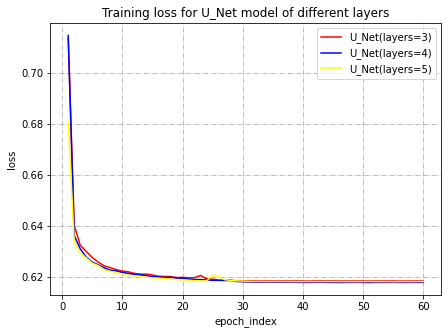

In [ ]:
plt.figure(figsize=(7,5),facecolor='white')
epoches_indices = np.arange(1, epoches+1)
l1 = plt.plot(epoches_indices,Train_Loss[0] , color = 'red',label = 'U_Net(layers=3)')
l2 = plt.plot(epoches_indices,Train_Loss[1] , color = 'blue',label = 'U_Net(layers=4)')
l3 = plt.plot(epoches_indices,Train_Loss[2] , color = 'yellow',label = 'U_Net(layers=5)')
plt.legend()
plt.grid(True, linestyle='-.')
plt.title('Training loss for U_Net model of different layers')
plt.xlabel('epoch_index')
plt.ylabel("loss")
plt.savefig('/content/drive/My Drive/Colab/ML_road_segment_classfication/scratch_UNet/layer_selection.png')
plt.show()

From above results in different U_Net structure, the U_Net with 4 layers and 5 layers have almost equal accuracy. However, the more complicated the structure is, the more time and computaion it will consume. Therefore, for the rest validation procedure, it's better to use the U_Net model with 4 layers to find the best parameters.


##### 2. To choose the best patch_size and overlap pairs


In [ ]:
perm_index = np.random.permutation(np.arange(1, train_size + 1)) # to shuffle the 100 images
train_80_indices = perm_index[:80]  # 80 images as training data
val_20_indices = perm_index[-20:]   # 20 images as validation data

In [ ]:
patch_size = 80
epoches = 60

Train_Loss_80 = []  # patch_size = 80
Val_loss_80 = []

for i in [10,20,40]:  # different overlaping steps
  train_80_set = Patch_dataset(imag_path, label_path, train_80_indices, patch_size, overlap=True, step = i)
  val_20_set = Patch_dataset(imag_path, label_path, val_20_indices, patch_size, overlap=True, step = i)

  train_80_loader = DataLoader(train_80_set, batch_size = 128, shuffle=True)
  val_20_loader = DataLoader(val_20_set, batch_size = 128, shuffle=False)

  layers, channel_sizes = Unet_setting(layers = 4)
  model = Unet(layers, channel_sizes).cuda()
  criterion = torch.nn.BCEWithLogitsLoss().cuda()
  optimizer = Adam(model.parameters(), lr=0.001)
  lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, verbose=True)

  loss_set, val_loss = Val_Training_process(model, epoches, criterion, optimizer, lr_scheduler, train_80_loader, val_20_loader, cuda=True)

  Train_Loss_80.append(loss_set)
  Val_loss_80.append(val_loss)

Loading 80 satlite images...Loading 80 satlite images...Loading 20 satlite images...Loading 20 satlite images...Starting to train the U_Net Model...
training the No.1 epoch, loss: 0.6546
training the No.2 epoch, loss: 0.6368
training the No.3 epoch, loss: 0.6332
training the No.4 epoch, loss: 0.6306
training the No.5 epoch, loss: 0.6294
training the No.6 epoch, loss: 0.6271
training the No.7 epoch, loss: 0.6261
training the No.8 epoch, loss: 0.6254
training the No.9 epoch, loss: 0.6246
training the No.10 epoch, loss: 0.6238
training the No.11 epoch, loss: 0.6236
training the No.12 epoch, loss: 0.6237
training the No.13 epoch, loss: 0.6230
training the No.14 epoch, loss: 0.6225
training the No.15 epoch, loss: 0.6225
training the No.16 epoch, loss: 0.6224
training the No.17 epoch, loss: 0.6220
training the No.18 epoch, loss: 0.6222
training the No.19 epoch, loss: 0.6217
training the No.20 epoch, loss: 0.6215
training the No.21 epoch, loss: 0.6216
training the No.22 epoch, loss: 0.6217
Ep

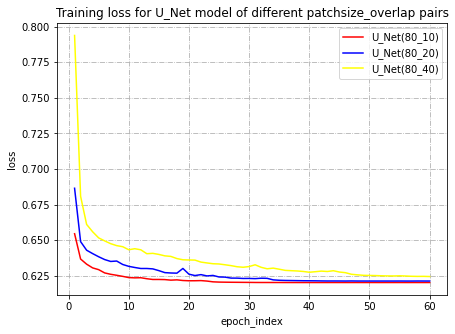

In [ ]:
plt.figure(figsize=(7,5),facecolor='white')
epoches_indices = np.arange(1, epoches+1)
l1 = plt.plot(epoches_indices,Train_Loss_80[0] , color = 'red',label = 'U_Net(80_10)')
l2 = plt.plot(epoches_indices,Train_Loss_80[1] , color = 'blue',label = 'U_Net(80_20)')
l3 = plt.plot(epoches_indices,Train_Loss_80[2] , color = 'yellow',label = 'U_Net(80_40)')
plt.legend()
plt.grid(True, linestyle='-.')
plt.title('Training loss for U_Net model of different patchsize_overlap pairs')
plt.xlabel('epoch_index')
plt.ylabel("loss")
plt.savefig('/content/drive/My Drive/Colab/ML_road_segment_classfication/scratch_UNet/patch80.png')
plt.show()

In [ ]:
for i in range(3):
  print('U_Net(patchsize=80; overlap steps={:2d}): validation loss is {:6f}'.format([10,20,40][i], Val_loss_80[i]))

U_Net(patchsize=80; overlap steps=10): validation loss is 0.634555
U_Net(patchsize=80; overlap steps=20): validation loss is 0.632915
U_Net(patchsize=80; overlap steps=40): validation loss is 0.636762


In [ ]:
patch_size = 160
epoches = 60

Train_Loss_160 = []  # patch_size = 160
Val_loss_160 = []

for i in [10,20,40,80]:
  train_80_set = Patch_dataset(imag_path, label_path, train_80_indices, patch_size, overlap=True, step = i)
  val_20_set = Patch_dataset(imag_path, label_path, val_20_indices, patch_size, overlap=True, step = i)

  train_80_loader = DataLoader(train_80_set, batch_size = 128, shuffle=True)
  val_20_loader = DataLoader(val_20_set, batch_size = 128, shuffle=False)

  layers, channel_sizes = Unet_setting(layers = 4)
  model = Unet(layers, channel_sizes).cuda()
  criterion = torch.nn.BCEWithLogitsLoss().cuda()
  optimizer = Adam(model.parameters(), lr=0.001)
  lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, verbose=True)

  loss_set, val_loss = Val_Training_process(model, epoches, criterion, optimizer, lr_scheduler, train_80_loader, val_20_loader, cuda=True)

  Train_Loss_160.append(loss_set)
  Val_loss_160.append(val_loss)

Loading 80 satlite images...Loading 80 satlite images...Loading 20 satlite images...Loading 20 satlite images...Starting to train the U_Net Model...
training the No.1 epoch, loss: 0.6489
training the No.2 epoch, loss: 0.6271
training the No.3 epoch, loss: 0.6240
training the No.4 epoch, loss: 0.6228
training the No.5 epoch, loss: 0.6222
training the No.6 epoch, loss: 0.6217
training the No.7 epoch, loss: 0.6214
training the No.8 epoch, loss: 0.6211
training the No.9 epoch, loss: 0.6209
training the No.10 epoch, loss: 0.6207
training the No.11 epoch, loss: 0.6205
training the No.12 epoch, loss: 0.6204
training the No.13 epoch, loss: 0.6203
training the No.14 epoch, loss: 0.6204
Epoch    15: reducing learning rate of group 0 to 1.0000e-04.
training the No.15 epoch, loss: 0.6201
training the No.16 epoch, loss: 0.6197
training the No.17 epoch, loss: 0.6197
training the No.18 epoch, loss: 0.6197
training the No.19 epoch, loss: 0.6196
training the No.20 epoch, loss: 0.6196
training the No.21

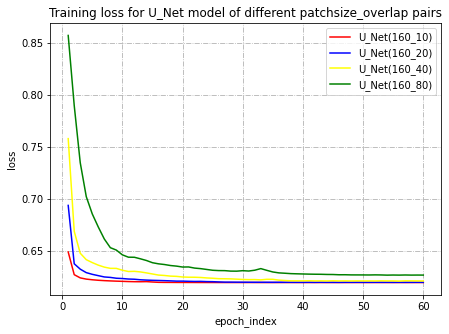

In [ ]:
plt.figure(figsize=(7,5),facecolor='white')
epoches_indices = np.arange(1, epoches+1)
l1 = plt.plot(epoches_indices,Train_Loss_160[0] , color = 'red',label = 'U_Net(160_10)')
l2 = plt.plot(epoches_indices,Train_Loss_160[1] , color = 'blue',label = 'U_Net(160_20)')
l3 = plt.plot(epoches_indices,Train_Loss_160[2] , color = 'yellow',label = 'U_Net(160_40)')
l3 = plt.plot(epoches_indices,Train_Loss_160[3] , color = 'green',label = 'U_Net(160_80)')
plt.legend()
plt.grid(True, linestyle='-.')
plt.title('Training loss for U_Net model of different patchsize_overlap pairs')
plt.xlabel('epoch_index')
plt.ylabel("loss")
plt.savefig('/content/drive/My Drive/Colab/ML_road_segment_classfication/scratch_UNet/patch160.png')
plt.show()

In [ ]:
for i in range(4):
  print('U_Net(patchsize=160; overlap steps={:2d}): validation loss is {:6f}'.format([10,20,40,80][i], Val_loss_160[i]))

U_Net(patchsize=160; overlap steps=10): validation loss is 0.638405
U_Net(patchsize=160; overlap steps=20): validation loss is 0.638409
U_Net(patchsize=160; overlap steps=40): validation loss is 0.638794
U_Net(patchsize=160; overlap steps=80): validation loss is 0.638238


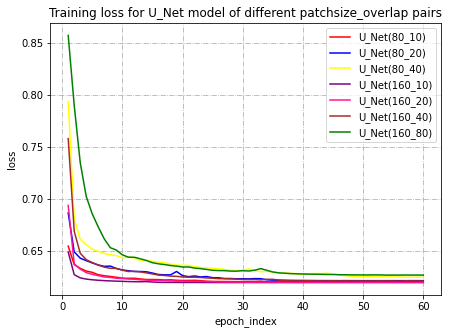

In [ ]:
plt.figure(figsize=(7,5),facecolor='white')
epoches_indices = np.arange(1, epoches+1)
l1 = plt.plot(epoches_indices,Train_Loss_80[0] , color = 'red',label = 'U_Net(80_10)')
l2 = plt.plot(epoches_indices,Train_Loss_80[1] , color = 'blue',label = 'U_Net(80_20)')
l3 = plt.plot(epoches_indices,Train_Loss_80[2] , color = 'yellow',label = 'U_Net(80_40)')
l4 = plt.plot(epoches_indices,Train_Loss_160[0] , color = 'purple',label = 'U_Net(160_10)')
l5 = plt.plot(epoches_indices,Train_Loss_160[1] , color = 'deeppink',label = 'U_Net(160_20)')
l6 = plt.plot(epoches_indices,Train_Loss_160[2] , color = 'brown',label = 'U_Net(160_40)')
l7 = plt.plot(epoches_indices,Train_Loss_160[3] , color = 'green',label = 'U_Net(160_80)')
plt.legend()
plt.grid(True, linestyle='-.')
plt.title('Training loss for U_Net model of different patchsize_overlap pairs')
plt.xlabel('epoch_index')
plt.ylabel("loss")
plt.savefig('/content/drive/My Drive/Colab/ML_road_segment_classfication/scratch_UNet/patch160_80.png')
plt.show()

In [ ]:
for i in range(3):
  print('U_Net(patchsize=80; overlap steps={:2d}): validation loss is {:6f}'.format([10,20,40][i], Val_loss_80[i]))

for i in range(4):
  print('U_Net(patchsize=160; overlap steps={:2d}): validation loss is {:6f}'.format([10,20,40,80][i], Val_loss_160[i]))

U_Net(patchsize=80; overlap steps=10): validation loss is 0.634555
U_Net(patchsize=80; overlap steps=20): validation loss is 0.632915
U_Net(patchsize=80; overlap steps=40): validation loss is 0.636762
U_Net(patchsize=160; overlap steps=10): validation loss is 0.638405
U_Net(patchsize=160; overlap steps=20): validation loss is 0.638409
U_Net(patchsize=160; overlap steps=40): validation loss is 0.638794
U_Net(patchsize=160; overlap steps=80): validation loss is 0.638238




##### 3. To add feature augmentation strategies


In [ ]:
import cv2
def flip(x):  # x: dataset; dim: how to flip, 1:vertically; 2:horizontally
    
    hor = cv2.flip(x, 0)
    ver = cv2.flip(x, 1)
    
    return hor, ver

In [ ]:
def remove_shadow(patch):
    """
    Due to the rotation, the image will be enlarged 
    and get more shadow areas(above fig). Hence it 
    is better to remove these useless pixels and then
    get patches.
    """
    lt = not np.any(patch[0,0])
    rt = not np.any(patch[0,-1])
    lb = not np.any(patch[-1,0])
    rb = not np.any(patch[-1,-1])

    return lt or rt or lb or rb

In [ ]:
import imutils
def rotation(x, angle):
    return imutils.rotate_bound(x, angle)

In [ ]:
def prepare_augment_trainset(imag_path, label_path, imag_indices, patch_size, overlap, step, Flip=False, rotation_angle=False):
    images = load_data_set(imag_path, imag_indices)
    labels = load_data_set(label_path, imag_indices)
    
    if Flip:
        flipped_images = [f for im in images for f in flip(im)]
        flipped_labels = [f for label in labels for f in flip(label)]
        
        images.extend(flipped_images)
        labels.extend(flipped_labels)
    
    if rotation_angle:
        rotated_images = [rotation(im, rotation_angle) for im in images]
        rotated_labels = [rotation(label, rotation_angle) for label in labels]
        
        images.extend(rotated_images)
        labels.extend(rotated_labels)
    
    if overlap:
        image_patches = [patch for im in images for patch in get_patch_ovelap(im, patch_size, step)]
        label_patches = [patch for label in labels for patch in get_patch_ovelap(label, patch_size, step)]
    if not overlap:
        image_patches = [patch for im in images for patch in get_patch(im, patch_size)]
        label_patches = [patch for label in labels for patch in get_patch(label, patch_size)]

    if not rotation_angle:
      return image_patches, label_patches

    if rotation_angle:
        image_patches_rotated = [image_patches[i] for i in range(len(image_patches)) if not remove_shadow(image_patches[i])]
        label_patches_ratated = [label_patches[i] for i in range(len(image_patches)) if not remove_shadow(image_patches[i])]
    
        return image_patches_rotated, label_patches_ratated

In [ ]:
class Patch_augment_dataset(Dataset):
    
    def __init__(self, imag_path, label_path, imag_indices, patch_size, overlap, step, Flip, rotation_angle):
        self.patch_feat, self.patch_label = prepare_augment_trainset(imag_path, label_path, imag_indices, patch_size, overlap, step, Flip, rotation_angle)
        
    def __getitem__(self,index): # design get function according to index
        patch_feat = torch.from_numpy(np.transpose(self.patch_feat[index],(2,0,1))) #each data patch contain 3 channels. Each channel is in patch_size x patch_size
        patch_label = label_to_torch(self.patch_label[index])
        
        return patch_feat, patch_label
    
    def __len__(self):
        return(len(self.patch_feat))
        

In [ ]:
perm_index = np.random.permutation(np.arange(1, train_size + 1)) # to shuffle the 100 images
train_80_indices = perm_index[:80]  # 80 images as training data
val_20_indices = perm_index[-20:]   # 20 images as validation data

From previous results, (layers=4, patch_size=80, overlap_steps=20) is the best parameter pair

In [ ]:
patch_size = 80
epoches = 60

Train_Loss_aug = []  
Val_loss_aug = []

for j in [True, False]:
  for id in [30, 45, 60]:

    train_80_set = Patch_augment_dataset(imag_path, label_path, train_80_indices, patch_size, overlap=True, step=20, Flip=j, rotation_angle=i)
    val_20_set = Patch_augment_dataset(imag_path, label_path, val_20_indices, patch_size, overlap=True, step=20, Flip=False, rotation_angle=False)

    train_80_loader = DataLoader(train_80_set, batch_size = 128, shuffle=True)
    val_20_loader = DataLoader(val_20_set, batch_size = 128, shuffle=False)

    layers, channel_sizes = Unet_setting(layers = 4)
    model = Unet(layers, channel_sizes).cuda()
    criterion = torch.nn.BCEWithLogitsLoss().cuda()
    optimizer = Adam(model.parameters(), lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, verbose=True)

    loss_set, val_loss = Val_Training_process(model, epoches, criterion, optimizer, lr_scheduler, train_80_loader, val_20_loader, cuda=True)

    Train_Loss_aug.append(loss_set)
    Val_loss_aug.append(val_loss)

Loading 80 satlite images...Loading 80 satlite images...Loading 20 satlite images...Loading 20 satlite images...Starting to train the U_Net Model...
training the No.1 epoch, loss: 0.6573
training the No.2 epoch, loss: 0.6404
training the No.3 epoch, loss: 0.6365
training the No.4 epoch, loss: 0.6338
training the No.5 epoch, loss: 0.6321
training the No.6 epoch, loss: 0.6306
training the No.7 epoch, loss: 0.6296
training the No.8 epoch, loss: 0.6285
training the No.9 epoch, loss: 0.6276
training the No.10 epoch, loss: 0.6272
training the No.11 epoch, loss: 0.6262
training the No.12 epoch, loss: 0.6259
training the No.13 epoch, loss: 0.6253
training the No.14 epoch, loss: 0.6255
training the No.15 epoch, loss: 0.6247
training the No.16 epoch, loss: 0.6244
training the No.17 epoch, loss: 0.6243
training the No.18 epoch, loss: 0.6239
training the No.19 epoch, loss: 0.6237
training the No.20 epoch, loss: 0.6235
training the No.21 epoch, loss: 0.6234
training the No.22 epoch, loss: 0.6233
tr

In [ ]:
Val_loss_aug

[0.6396786285483319,
 0.6389575678369274,
 0.6393718849057737,
 0.6388917500558107,
 0.6403321934782941,
 0.6380141260831252]

In [ ]:
patch_size = 80
epoches = 60

Train_Loss_flip = []  
Val_loss_flip = []

for j in [True, False]:
  
  train_80_set = Patch_augment_dataset(imag_path, label_path, train_80_indices, patch_size, overlap=True, step=20, Flip=j, rotation_angle=False)
  val_20_set = Patch_augment_dataset(imag_path, label_path, val_20_indices, patch_size, overlap=True, step=20, Flip=False, rotation_angle=False)

  train_80_loader = DataLoader(train_80_set, batch_size = 128, shuffle=True)
  val_20_loader = DataLoader(val_20_set, batch_size = 128, shuffle=False)

  layers, channel_sizes = Unet_setting(layers = 4)
  model = Unet(layers, channel_sizes).cuda()
  criterion = torch.nn.BCEWithLogitsLoss().cuda()
  optimizer = Adam(model.parameters(), lr=0.001)
  lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, verbose=True)

  loss_set, val_loss = Val_Training_process(model, epoches, criterion, optimizer, lr_scheduler, train_80_loader, val_20_loader, cuda=True)

  Train_Loss_flip.append(loss_set)
  Val_loss_flip.append(val_loss)

Loading 80 satlite images...Loading 80 satlite images...Loading 20 satlite images...Loading 20 satlite images...Starting to train the U_Net Model...
training the No.1 epoch, loss: 0.6619
training the No.2 epoch, loss: 0.6438
training the No.3 epoch, loss: 0.6398
training the No.4 epoch, loss: 0.6373
training the No.5 epoch, loss: 0.6348
training the No.6 epoch, loss: 0.6329
training the No.7 epoch, loss: 0.6316
training the No.8 epoch, loss: 0.6304
training the No.9 epoch, loss: 0.6298
training the No.10 epoch, loss: 0.6285
training the No.11 epoch, loss: 0.6278
training the No.12 epoch, loss: 0.6272
training the No.13 epoch, loss: 0.6268
training the No.14 epoch, loss: 0.6262
training the No.15 epoch, loss: 0.6254
training the No.16 epoch, loss: 0.6250
training the No.17 epoch, loss: 0.6249
training the No.18 epoch, loss: 0.6244
training the No.19 epoch, loss: 0.6242
training the No.20 epoch, loss: 0.6240
training the No.21 epoch, loss: 0.6238
training the No.22 epoch, loss: 0.6235
tr

In [ ]:
print('Scenario Basic: validation loss is {:6f}'.format(Val_loss_flip[1]))
print('Scenario only Flip: validation loss is {:6f}'.format(Val_loss_flip[0]))

for i in range(3):
    print('Scenario only Rotaion({:2d}): validation loss is {:6f}'.format([30, 45, 60][i], Val_loss_aug[i+3]))

for i in range(3):
    print('Scenario with Flip and Rotaion({:2d}): validation loss is {:6f}'.format([30, 45, 60][i], Val_loss_aug[i]))

Scenario Basic: validation loss is 0.638117
Scenario only Flip: validation loss is 0.639852
Scenario only Rotaion(30): validation loss is 0.638892
Scenario only Rotaion(45): validation loss is 0.640332
Scenario only Rotaion(60): validation loss is 0.638014
Scenario with Flip and Rotaion(30): validation loss is 0.639679
Scenario with Flip and Rotaion(45): validation loss is 0.638958
Scenario with Flip and Rotaion(60): validation loss is 0.639372


From the validation results above, the structure with (layers=4, patch_size=80, overlpa steps=20, Flip=None, Rotation=60) has the highest accuracy

#### Final Training Process

According to previous parameter selection, to train the best model

In [ ]:
patch_size = 80

Train_set = Patch_augment_dataset(imag_path, label_path, imag_indices, patch_size, overlap=True, step=20, Flip=False, rotation_angle=60)
trainloader = DataLoader(Train_set, batch_size = 128, shuffle=True)

Loading 100 satlite images...Loading 100 satlite images...

In [ ]:
layers, channel_sizes = Unet_setting(layers=4)
model = Unet(layers, channel_sizes).cuda()
criterion = torch.nn.BCEWithLogitsLoss().cuda()
optimizer = Adam(model.parameters(), lr=0.001)
epoches = 70
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
  #lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.9,last_epoch=-1,verbose=True)
#
Training_process(model, epoches, criterion, optimizer, lr_scheduler, Train_set, trainloader, patch_size, cuda=True)

Starting to train the U_Net model...
training the No.1 epoch, loss: 0.6758
training the No.2 epoch, loss: 0.6470
training the No.3 epoch, loss: 0.6423
training the No.4 epoch, loss: 0.6388
training the No.5 epoch, loss: 0.6361
training the No.6 epoch, loss: 0.6350
training the No.7 epoch, loss: 0.6341
training the No.8 epoch, loss: 0.6325
training the No.9 epoch, loss: 0.6308
training the No.10 epoch, loss: 0.6304
training the No.11 epoch, loss: 0.6295
training the No.12 epoch, loss: 0.6281
training the No.13 epoch, loss: 0.6276
training the No.14 epoch, loss: 0.6269
training the No.15 epoch, loss: 0.6262
training the No.16 epoch, loss: 0.6267
training the No.17 epoch, loss: 0.6260
training the No.18 epoch, loss: 0.6249
training the No.19 epoch, loss: 0.6244
training the No.20 epoch, loss: 0.6242
training the No.21 epoch, loss: 0.6245
training the No.22 epoch, loss: 0.6239
training the No.23 epoch, loss: 0.6231
training the No.24 epoch, loss: 0.6232
training the No.25 epoch, loss: 0.62

To predict the test dataset and get the submission.csv file to require the F1 score

In [ ]:
label_size = 608
subm_patch_size = 16
threshold = 0.25

prediction = Test(model, testloader, cuda=True)  # to get each image's prediction by pixel
  
patch_labels = [pred_to_patch_approx(pred, label_size, subm_patch_size, threshold) for pred in prediction]  # to transform pixel predicition into patch approxiamation
pred_submission = pixel_to_patch(patch_labels, subm_patch_size)   # to seperate each patch
  
submission_path = '/content/drive/My Drive/Colab/ML_road_segment_classfication/scratch_UNet/submission.csv'  
submission(submission_path, test_size, label_size, subm_patch_size)  # to write each patch prediction in the submission.csv

From the f1 score feedback on AI website, this is not very ideal for the test dataset. The reason maybe that the validation does not include all the possible data to test. In this project, we did not use the cross validation method since the training durition is so long. Therefore the validation process maybe more specific for this validation dataset. 
Hence it'd better use the flip with rotation way to preprocess the data since more augmentation will produce more different information. So we use the (layers=4, patch_size=80, overlap_steps=20, Flip=True, Rotation=45) U_Net structure to train our final model.

In [ ]:
patch_size = 80

Train_set = Patch_augment_dataset(imag_path, label_path, imag_indices, patch_size, overlap=True, step=20, Flip=True, rotation_angle=45)
trainloader = DataLoader(Train_set, batch_size = 128, shuffle=True)

Loading 100 satlite images...Loading 100 satlite images...

In [ ]:
layers, channel_sizes = Unet_setting(layers=4)
model = Unet(layers, channel_sizes).cuda()
criterion = torch.nn.BCEWithLogitsLoss().cuda()
optimizer = Adam(model.parameters(), lr=0.001)
epoches = 70
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
  #lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.9,last_epoch=-1,verbose=True)
#
Training_process(model, epoches, criterion, optimizer, lr_scheduler, Train_set, trainloader, patch_size, cuda=True)

Starting to train the U_Net model...
training the No.1 epoch, loss: 0.6578
training the No.2 epoch, loss: 0.6421
training the No.3 epoch, loss: 0.6374
training the No.4 epoch, loss: 0.6350
training the No.5 epoch, loss: 0.6332
training the No.6 epoch, loss: 0.6316
training the No.7 epoch, loss: 0.6305
training the No.8 epoch, loss: 0.6295
training the No.9 epoch, loss: 0.6286
training the No.10 epoch, loss: 0.6278
training the No.11 epoch, loss: 0.6271
training the No.12 epoch, loss: 0.6266
training the No.13 epoch, loss: 0.6261
training the No.14 epoch, loss: 0.6256
training the No.15 epoch, loss: 0.6251
training the No.16 epoch, loss: 0.6249
training the No.17 epoch, loss: 0.6245
training the No.18 epoch, loss: 0.6243
training the No.19 epoch, loss: 0.6240
training the No.20 epoch, loss: 0.6237
training the No.21 epoch, loss: 0.6234
training the No.22 epoch, loss: 0.6234
training the No.23 epoch, loss: 0.6231
training the No.24 epoch, loss: 0.6229
training the No.25 epoch, loss: 0.62

In [ ]:
label_size = 608
subm_patch_size = 16
threshold = 0.25

prediction = Test(model, testloader, cuda=True)  # to get each image's prediction by pixel
  
patch_labels = [pred_to_patch_approx(pred, label_size, subm_patch_size, threshold) for pred in prediction]  # to transform pixel predicition into patch approxiamation
pred_submission = pixel_to_patch(patch_labels, subm_patch_size)   # to seperate each patch
  
submission_path = '/content/drive/My Drive/Colab/ML_road_segment_classfication/scratch_UNet/submission.csv'  
submission(submission_path, test_size, label_size, subm_patch_size)  # to write each patch prediction in the submission.csv

From the AICrowd feedback, this model has higher f1 score: 0.9/0.947. So this is will be used as the final model

To save the model parameters for evaluation

In [ ]:
PATH = '/content/drive/My Drive/Colab/ML_road_segment_classfication/scratch_UNet/U_Net_parameters.pt'
torch.save(model.state_dict(), PATH)

In [ ]:
layers, channel_sizes = Unet_setting(layers=4)
net = Unet(layers, channel_sizes).cuda()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
import pandas as pd
df = pd.DataFrame(list())
df.to_csv('/content/drive/My Drive/Colab/ML_road_segment_classfication/scratch_UNet/submission.csv')

In [ ]:
label_size = 608
subm_patch_size = 16
threshold = 0.25

prediction = Test(net, testloader, cuda=True)  # to get each image's prediction by pixel
  
patch_labels = [pred_to_patch_approx(pred, label_size, subm_patch_size, threshold) for pred in prediction]  # to transform pixel predicition into patch approxiamation
pred_submission = pixel_to_patch(patch_labels, subm_patch_size)   # to seperate each patch
  
submission_path = '/content/drive/My Drive/Colab/ML_road_segment_classfication/scratch_UNet/submission.csv'  
submission(submission_path, test_size, label_size, subm_patch_size, pred_submission)  # to write each patch prediction in the submission.csv

From the laod method, net has same f1 score as the model. So the saving for best model parameters is successful

To visualize the prediction on the satellite image

In [ ]:
from PIL import Image

In [ ]:
def img_float_to_uint8(img):
    """
    Transform float image to uint image.
    """
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

def make_img_overlay(img, predicted_img):
    """
    Display prediction overlay on top of original image.
    """
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

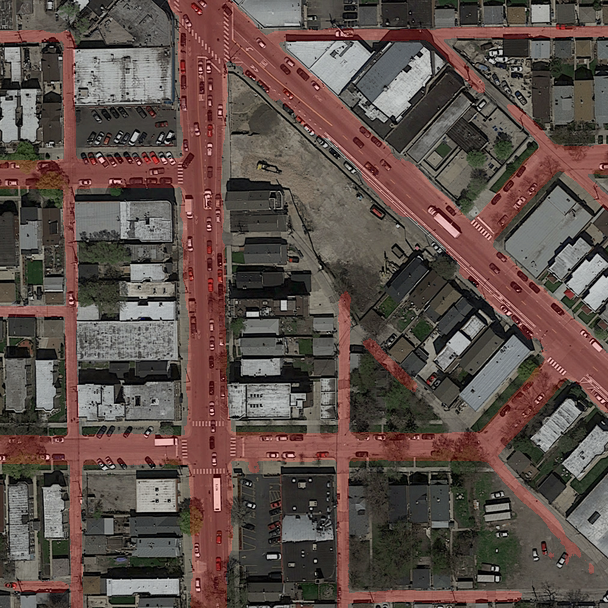

In [ ]:
make_img_overlay(np.transpose(Test_set[10],(1,2,0)).numpy(), prediction[10])

This is one example for road classification

In [ ]:
!python3 '/content/drive/My Drive/Colab/ML_road_segment_classfication/scratch_UNet/run_loadmodel.py'

Loading 50 satlite images...

In [2]:
!python3 '/content/drive/My Drive/Colab/ML_road_segment_classfication/scratch_UNet/run.py'

Loading 50 satlite images...Loading 100 satlite images...Loading 100 satlite images...Starting to train the U_Net model...
training the No.1 epoch, loss: 0.6687
training the No.2 epoch, loss: 0.6494
